# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=810081e44d38dd889e45900e9f0cb11f0a7e15ea876b9e3ebc39d0c7a9c0e4f2
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=9265deb49dc060b44475a5eeb28a116276e29643470b49b52a59799fcc7a3320
  Stored in directory: /root/.cache/pip/w

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

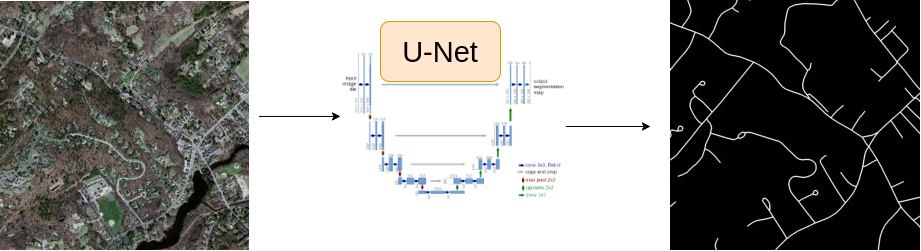

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 18.10 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMG_SIZE = 512
BATCH_SIZE = 8
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 15

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

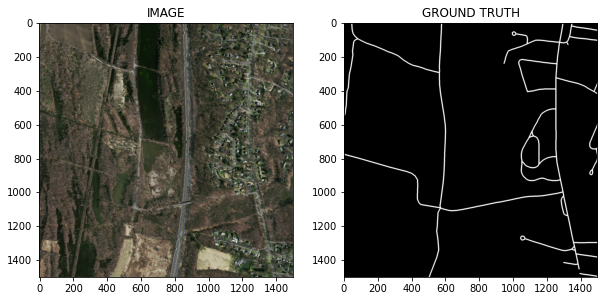

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

In [ ]:
len(train_df)

159

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_aug():
  return A.Compose([
       A.Resize(IMG_SIZE,IMG_SIZE), 
       A.HorizontalFlip(p=0.5),#50% change image will get flipped horizontally
       A.VerticalFlip(p=0.5)
  ])

def get_valid_aug():
  return A.Compose([
       A.Resize(IMG_SIZE,IMG_SIZE) 
       
  ])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations) :
    
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) => (c, h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float32) #channel was at index 2
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)
    
    # convert from numpy to tensor 
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)
    
    return image,mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_aug())
validset = SegmentationDataset(valid_df, get_valid_aug())

In [ ]:
for image, mask in trainset:
  break

print(f"image shape: {image.shape}")
print(f"mask shape: {mask.shape}")

image shape: torch.Size([3, 512, 512])
mask shape: torch.Size([1, 512, 512])


In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 159
Size of Validset : 40


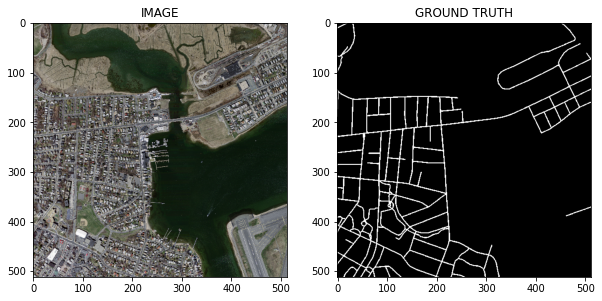

In [ ]:
idx = 3

image,mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [ ]:
print(f"total no of batches in trainloader:{len(trainloader)}")
print(f"total no of batches in validloader:{len(validloader)}")

total no of batches in trainloader:20
total no of batches in validloader:5


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([8, 3, 512, 512])
One batch mask shape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
   def __init__(self):
     super(SegmentationModel,self).__init__()
      # loading Unet architecture
     self.arc = smp.Unet(
         encoder_name = ENCODER,
         encoder_weights = WEIGHTS,
         in_channels = 3,
         classes = 1,
         activation = None
     )

   def forward(self,images,masks=None):

    logits = self.arc(images) #when images are passed to the architecture, they will output logits (masks)

    if masks != None:
      return logits, DiceLoss(mode='binary')(logits,masks) + nn.BCEWithLogitsLoss()(logits, masks) #testing time mask will be none as we don't have it
      
      
      
    
    return logits 
        

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader,model,optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader,model):

  model.eval() # turn OFF Batchnorm, dropout
  total_loss = 0.0
  
  with torch.no_grad(): # validation does not require gradient calculation
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      
      logits, loss = model(images, masks)
      

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader,model,optimizer)
  valid_loss = eval_fn(validloader,model)

  if valid_loss < best_valid_loss :
    torch.save(model.state_dict(),'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train Loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch: 1 Train Loss : 1.0325627624988556 Valid_loss : 0.9202459216117859


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED-MODEL
Epoch: 2 Train Loss : 0.7707335174083709 Valid_loss : 0.7595792174339294


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


SAVED-MODEL
Epoch: 3 Train Loss : 0.7121327549219132 Valid_loss : 0.7128416776657105


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


SAVED-MODEL
Epoch: 4 Train Loss : 0.6860716998577118 Valid_loss : 0.6995711088180542


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch: 5 Train Loss : 0.6564027518033981 Valid_loss : 0.7032452821731567


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


SAVED-MODEL
Epoch: 6 Train Loss : 0.6422533363103866 Valid_loss : 0.6586752891540527


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch: 7 Train Loss : 0.6408093512058258 Valid_loss : 0.622784411907196


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch: 8 Train Loss : 0.6383547335863113 Valid_loss : 0.6713497519493103


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 9 Train Loss : 0.6241743326187134 Valid_loss : 0.6436736464500428


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED-MODEL
Epoch: 10 Train Loss : 0.609818896651268 Valid_loss : 0.6106121122837067


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch: 11 Train Loss : 0.612735815346241 Valid_loss : 0.6125973701477051


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch: 12 Train Loss : 0.6251775979995727 Valid_loss : 0.6107898116111755


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch: 13 Train Loss : 0.6042654544115067 Valid_loss : 0.5780370950698852


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 14 Train Loss : 0.6172366201877594 Valid_loss : 0.6188357830047607


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch: 15 Train Loss : 0.6171182543039322 Valid_loss : 0.6023003578186035


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 16 Train Loss : 0.6091187998652459 Valid_loss : 0.673556673526764


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED-MODEL
Epoch: 17 Train Loss : 0.6017379999160767 Valid_loss : 0.5753381729125977


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch: 18 Train Loss : 0.5874817281961441 Valid_loss : 0.5810652732849121


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 19 Train Loss : 0.5964869663119317 Valid_loss : 0.5882461488246917


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch: 20 Train Loss : 0.5763125643134117 Valid_loss : 0.5821084141731262


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 21 Train Loss : 0.5909032538533211 Valid_loss : 0.6252196311950684


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 22 Train Loss : 0.5897400051355361 Valid_loss : 0.5854814946651459


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch: 23 Train Loss : 0.5796804204583168 Valid_loss : 0.5573836922645569


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch: 24 Train Loss : 0.5663552761077881 Valid_loss : 0.5484991073608398


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

SAVED-MODEL
Epoch: 25 Train Loss : 0.573762172460556 Valid_loss : 0.5312631309032441


# Task 9 : Inference

In [ ]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C,H,W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

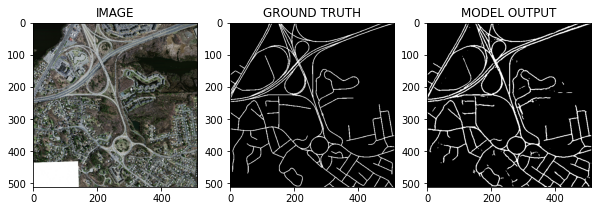

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

